In [2]:
%matplotlib inline

import numpy as np
import cv2

import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot

import matplotlib.pyplot as plt
from random import *
    
import src.paths
import src.filesystem
import src.colladaExport as dae

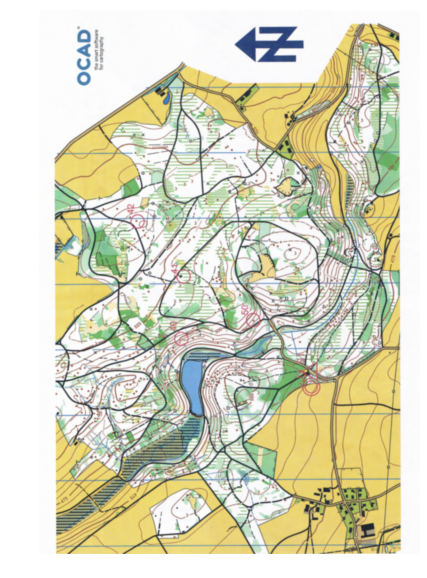

In [3]:
mapPath = "ressources/maps/map1.jpg" #"ressources/simplified/contourtest.jpg" #"ressources/maps/map1.jpg"
img = src.filesystem.readImg(mapPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

scale3d = 0.1

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

height, width, channels = img.shape
blank_image = np.zeros((height, width,1), np.uint8)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(img, interpolation="bicubic")
plt.show()

(4, 2)
3000


(3436, 2408, 1)


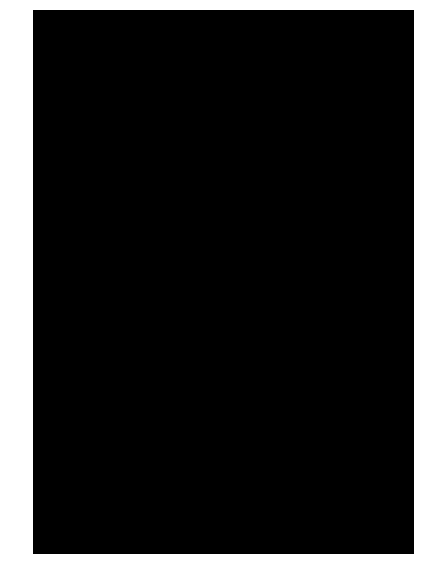

In [4]:


plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(img, interpolation="bicubic")

hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

lower_brown = np.array([0, 50, 50])
upper_brown = np.array([20, 255, 255])
filteredBrownsmask = cv2.inRange(hsv, lower_brown, upper_brown)
grayc = gray.copy()

mask = cv2.bitwise_and(grayc,grayc, mask=filteredBrownsmask)



contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #cv2.RETR_LIST

hierarchy = hierarchy[0]
    

print(np.array( [ [50,50], [50,150], [150, 150], [150,50] ] ).shape)


  
hmap = blank_image.copy()

def fillcontours(hier, conts, img, idx=0, iterations=0):
    curr = hier[idx]
    cont = conts[idx]
    next = curr[0]
    child = curr[2]
    
    l = cont.shape[0]
    
    points = np.empty((l, 2), dtype=np.uint8)
    
    for ptsn in enumerate(cont):
        i, pts = ptsn
        x, y = pts[0][0], pts[0][1]
        points[i][0] = y
        points[i][0] = x
        
    
    colorStep = 255//len(conts)
    c = colorStep* iterations
    cv2.fillPoly(img, pts=[cont], color=(c,c,c))
    
    if (child >= 0):
        fillcontours(hier, conts, img, child, iterations=iterations+1)
    
    if (next >= 0):
        fillcontours(hier, conts, img, next, iterations=iterations)
        

def findFirst(hier):
    curr = hier[0]
    idx = 0
    lastidx = 0
    while (curr[3] >= 0):
        curr = hier[curr[3]]
        lastidx = idx
        idx = curr[3]
    while (curr[1] >= 0):
        curr = hier[curr[1]]
        lastidx = idx
        idx = curr[1]
        
    return lastidx


import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(1000000)
idx = findFirst(hierarchy)
fillcontours(hierarchy, contours, blank_image, idx=idx)
print(hmap.shape)



contourmask = blank_image.copy()
cv2.drawContours(contourmask, contours, -1, (255, 255, 255), 1)

hmap = cv2.resize(hmap, (0,0), fx=scale3d, fy=scale3d,interpolation = cv2.INTER_AREA)

kernelsize = int((width+height)*scale3d)//2 + 1
hmap = cv2.GaussianBlur(hmap,(kernelsize, kernelsize),0)
hmap //= 4

tst = cv2.cvtColor(hmap, cv2.COLOR_GRAY2BGR)

plt.imshow(tst, interpolation="bicubic")
plt.show()


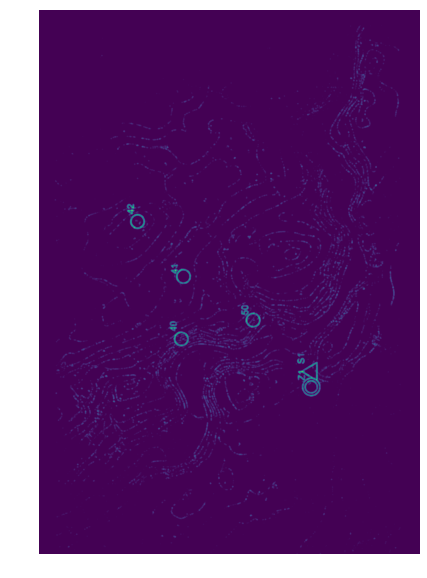

In [5]:
mask1 = cv2.inRange(hsv, np.array([0,70, 50]), np.array([0, 255, 255]))
mask2 = cv2.inRange(hsv, np.array([170, 70, 50]), np.array([180, 255, 255]))
mask = mask1 | mask2

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

[ 898 2076   45]
[1720 2380   40]
[1356 1960   42]
[ 912 1682   45]
[ 622 1336   45]
[1726 2348   68]


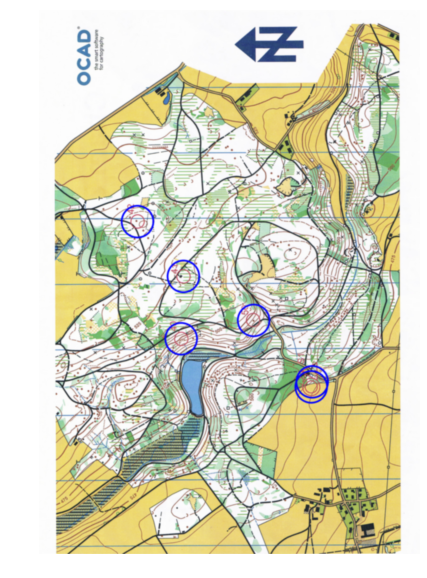

In [7]:
circles = cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, 1, 30,
              param1=30,
              param2=15,
              minRadius=10,
              maxRadius=100)
circles = np.uint16(np.around(circles))

imgToDraw = np.copy(img)
numberOfCheckpoints = 6
for circle in circles[0][:numberOfCheckpoints]:
    print(circle)
    cv2.circle(imgToDraw, (circle[0], circle[1]), 100, (0, 0, 255), 10)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(imgToDraw, interpolation="bicubic")

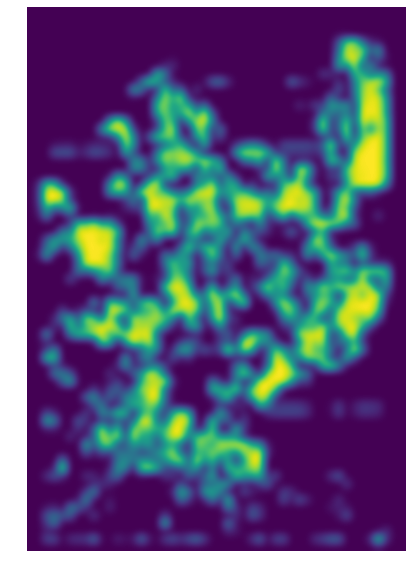

In [11]:
mask = cv2.inRange(hsv, np.array([60, 70, 150]), np.array([80, 255, 255]))

kernelsize = int((height+width/2)*0.002) + 1
kernel = np.ones((kernelsize,kernelsize),np.uint8)
mask = cv2.dilate(mask, kernel, iterations = 2)

treedensity=5

treesresized = cv2.resize(mask.copy(), (0,0), fx=scale3d/treedensity, fy=scale3d/treedensity,interpolation = cv2.INTER_AREA)
ret, treemap = cv2.threshold(treesresized,127,255,cv2.THRESH_BINARY)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(treesresized, interpolation="bicubic")

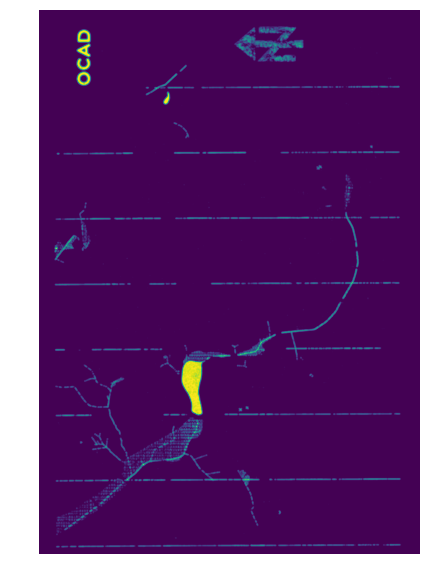

In [12]:
mask = cv2.inRange(hsv, np.array([100, 100, 120]), np.array([110, 255, 255]))

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

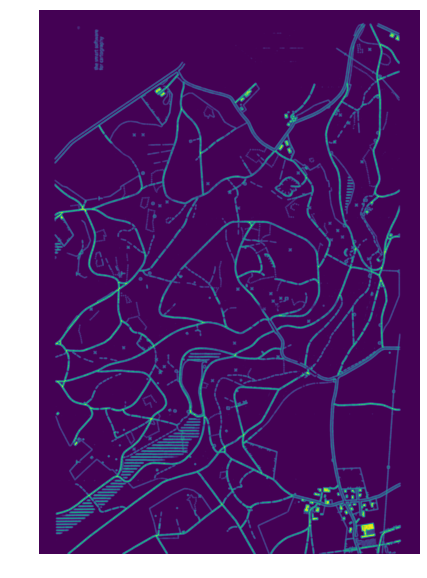

In [14]:
mask = cv2.inRange(hsv, np.array([0, 0, 0]), np.array([180, 255, 60]))

kernel = np.ones((5,5),np.uint8)
#mask = cv2.dilate(mask, kernel, iterations = 2)

plt.figure(figsize=[10,10])
plt.axis('off')
plt.imshow(mask, interpolation="bicubic")

In [17]:
mesh = dae.createMesh()
mesh = dae.createTerrain(hmap, mesh)
mesh = dae.addRessourcesToMesh(mesh, dae.tree)
mesh = dae.addRessourcesToMesh(mesh, dae.checkpoint)

x = np.array([[0.1, 0.0, 0.0, 1.86578654],
             [0.0, 0.1, 0.0, 0.0],
             [0.0, 0.0, 0.1, 20.33183994],
             [0.0, 0.0, 0.0, 1.0, ]])

s = scale3d/treedensity
cords = []
for x in range(treemap.shape[0]):
    for z in range(treemap.shape[1]):
        y = hmap[x*treedensity][z*treedensity]
        
        
        
        if (treemap[x][z] > 0):
            randomxdeflection = uniform(-treedensity,treedensity)
            randomzdeflection = uniform(-treedensity,treedensity)
            
            
            x_t = (x*treedensity + randomxdeflection)
            z_t = (z*treedensity + randomzdeflection)
            
            cords.append((x_t, -y, -z_t))


mesh = dae.addObjToMesh(mesh, dae.tree, 'tree', cords, scale=(s,s,s))

s = scale3d
cords = []          
for circle in circles[0][:numberOfCheckpoints]:
    z = int(circle[0]) *s
    x = int(circle[1])*s
    y = hmap[int(x)][int(z)]
    
    
    cords.append((x,-y,-z))
    
print(cords)
print(hmap.shape)
    
mesh = dae.addObjToMesh(mesh, dae.checkpoint, 'checkpoint', cords, scale=(s,s,s), rotation=(np.pi,0,0))

    


mesh.write('test.dae')

[(207.60000000000002, 0, -89.80000000000001), (238.0, 0, -172.0), (196.0, 0, -135.6), (168.20000000000002, 0, -91.2), (133.6, 0, -62.2), (234.8, 0, -172.60000000000002)]
(344, 241)
